TotalValue                     float64
Quantity                         int64
DaysSinceSignup                  int64
SignupDate              datetime64[ns]
Region_Europe                     bool
Region_North America              bool
Region_South America              bool
dtype: object


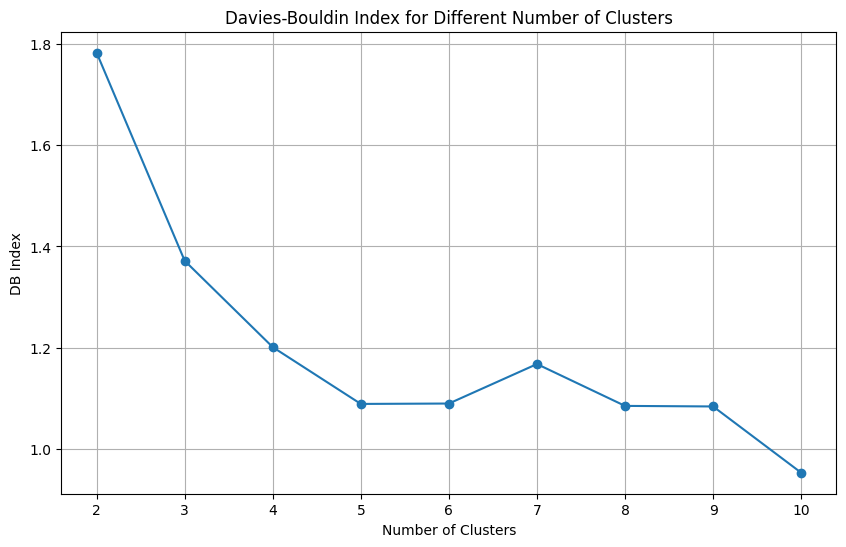

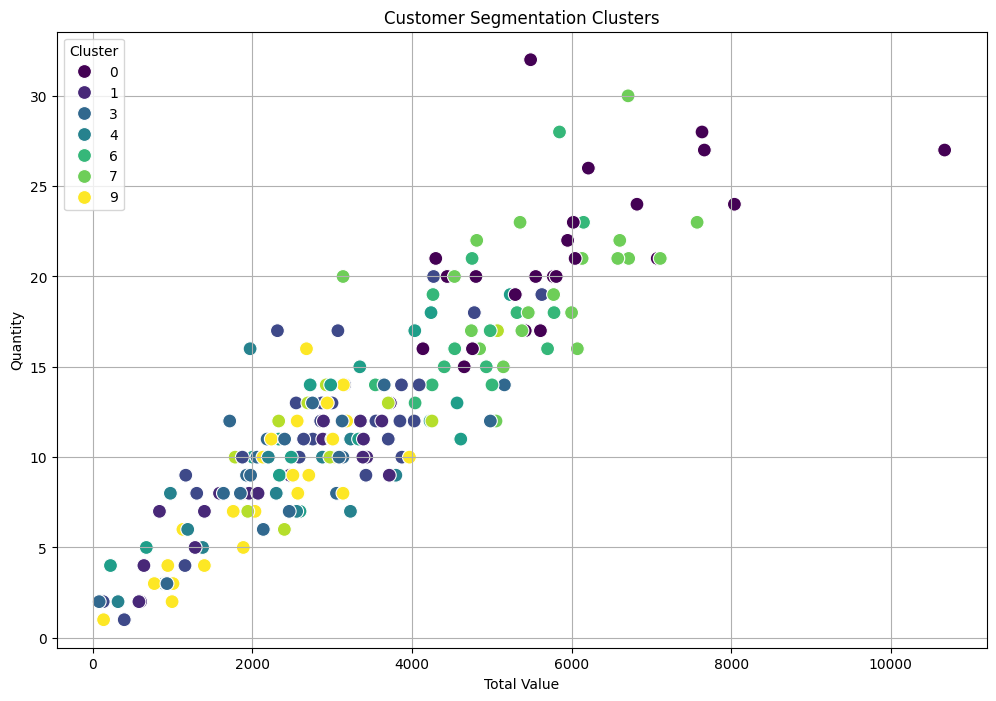

Optimal Number of Clusters: 10
Davies-Bouldin Index: 0.9523767989123426


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the Data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Step 2: Merge Data
# Merge transactions with customers to get customer profiles
merged_data = transactions.merge(customers, on='CustomerID')

# Create a summary of transactions per customer
customer_summary = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': 'first',  # Keep the region as part of the profile
    'SignupDate': 'first'  # Keep the signup date as part of the profile
}).reset_index()

# Step 3: Feature Engineering
# Convert categorical data to numerical
customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

# Convert SignupDate to datetime and extract features
customer_summary['SignupDate'] = pd.to_datetime(customer_summary['SignupDate'])
customer_summary['DaysSinceSignup'] = (pd.Timestamp.now() - customer_summary['SignupDate']).dt.days

# Prepare features for clustering
# Exclude non-numeric columns
features = customer_summary[['TotalValue', 'Quantity', 'DaysSinceSignup'] + list(customer_summary.columns[3:-1])]

# Check the features DataFrame to ensure it contains only numeric data
print(features.dtypes)

# Drop the 'SignupDate' column if it's still present
features = features.drop(columns=['SignupDate'], errors='ignore')

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 4: Clustering
# Experiment with different numbers of clusters
db_index_values = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(features_scaled, labels)
    db_index_values.append(db_index)

# Step 5: Visualize DB Index
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_index_values, marker='o')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(n_clusters_range)
plt.grid()
plt.show()

# Choose the optimal number of clusters (for example, based on the lowest DB Index)
optimal_n_clusters = n_clusters_range[db_index_values.index(min(db_index_values))]

# Fit the final model with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
final_kmeans.fit(features_scaled)
final_labels = final_kmeans.labels_

# Add cluster labels to the customer summary
customer_summary['Cluster'] = final_labels

# Step 6: Visualize Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=customer_summary['TotalValue'], y=customer_summary['Quantity'], hue=customer_summary['Cluster'], palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Value')
plt.ylabel('Quantity')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Step 7: Save the results
customer_summary.to_csv('Customer_Segmentation_Results.csv', index=False)

# Display the number of clusters and DB Index value
print(f'Optimal Number of Clusters: {optimal_n_clusters}')
print(f'Davies-Bouldin Index: {min(db_index_values)}')